<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Preliminary:-Potential-GDP" data-toc-modified-id="Preliminary:-Potential-GDP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preliminary: Potential GDP</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#HP-Filter" data-toc-modified-id="HP-Filter-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>HP Filter</a></span></li></ul></li></ul></li><li><span><a href="#Analysis-for-a-Particular-Country" data-toc-modified-id="Analysis-for-a-Particular-Country-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis for a Particular Country</a></span><ul class="toc-item"><li><span><a href="#Phillips-Curve" data-toc-modified-id="Phillips-Curve-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Phillips Curve</a></span></li><li><span><a href="#Okun's-Law" data-toc-modified-id="Okun's-Law-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Okun's Law</a></span></li></ul></li><li><span><a href="#Replication-Exercise" data-toc-modified-id="Replication-Exercise-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Replication Exercise</a></span></li></ul></div>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from pandas_datareader import wb, fred
import pandas as pd
import statsmodels.api as sm

import os


plot_defaults = {
    'figure.figsize':(14,4),
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(plot_defaults)

# Load Data

In [2]:
data_codes = [
    'NY.GDP.MKTP.KN', #GDP, constant LCU
    'SL.UEM.TOTL.ZS', #Unemployment, total, modeled ILO
    'SL.UEM.TOTL.NE.ZS', #Unemployment, total, national estimate
    'FP.CPI.TOTL.ZG', #CPI inflation
]

In [3]:
if not os.path.isdir('data'):
    os.mkdir('data')

In [4]:
if os.path.isfile('data/TD4_data.csv'):
    data = pd.read_csv('data/TD4_data.csv', parse_dates=['year'], infer_datetime_format=True, index_col=['country', 'year'])

else:
    data = wb.download(country='all', indicator=data_codes, start=1900, end=2022)
    data.columns = ['GDP', 'Unemployment_ILO', 'Unemployment_National', 'Inflation']
    data.reset_index(inplace=True)
    data.year = pd.to_datetime(data.year)
    data.set_index(['country', 'year'], inplace=True)
    data.sort_index(level=[0, 1])
    data.to_csv('data/TD4_data.csv')

# Preliminary: Potential GDP

In our equations we always write down potential GPD. What on earth is potential GDP? It's how much the economy "should" produce. How do we define it? According to [Rosnick (2016)](http://www.obela.org/system/files/Potential%20for%20Trouble,%20The%20IMF%C2%B4s%20Estimates%20of%20Potential%20GDP_David%20Rosnick.pdf):

>Unfortunately, potential GDP is neither directly measurable nor nearly as well defined as GDP, allowing economists considerable discretion in forming their estimates.

Rosnick cites [this IMF report](https://ieo.imf.org/~/media/IEO/Files/evaluations/completed/03-18-2014-imf-forecasts-process-quality-and-country-perspectives/bp-14-01-an-assessment-of-imf-medium-term.ashx) that interviewed country economists and asked how they compute potential GDP for the country they work on. It notes that:

>The HP filter, for instance, is a very popular method in general, and is widely used by IMF desk economists, according to interviews conducted by the evaluation team.

Both Rosnick (2016) and the IMF report go on to criticize the HP Filter. In fact, everyone criticizes the HP filter lately, but it remains popular because it's dirt easy to use, as we will see.


In [5]:
fred_codes = [
    'GDPC1', # Real Gross GDP  
    'GDPPOT' # Real Potential GDP
]

In [6]:
if os.path.isfile('data/usa_gdp_potential.csv'):
    fred_data = pd.read_csv('data/usa_gdp_potential.csv', parse_dates=['DATE'], infer_datetime_format=True, index_col=['DATE'])

else:
    fred_data = fred.FredReader(fred_codes, start=1900, end=2022).read()
    fred_data.reset_index(inplace=True)
    fred_data.DATE = pd.to_datetime(fred_data.DATE)
    fred_data.set_index('DATE', inplace=True)
    fred_data.to_csv('data/usa_gdp_potential.csv')

In [7]:
fred_data.head()

,GDPC1,GDPPOT
DATE,,
1947-01-01,2034.450,NaN
1947-04-01,2029.024,NaN
1947-07-01,2024.834,NaN
1947-10-01,2056.508,NaN
1948-01-01,2087.442,NaN


In [8]:
# remove missing values
fred_data.dropna(inplace=True)

# We only want to work with GDP data for now, so pull it out into its own variable
y = fred_data.GDPC1

Since the index of our data is a DateTime object, we can tell Pandas what the frequency of the data is. Actually it already can guess, but we still need to tell it that the guess is right.

In [9]:
# Pandas guesses that our data is quarterly (Q), counting from the start of the quarter (S), and that the last quarter is in October (OCT)
y.index.inferred_freq

'QS-OCT'

In [10]:
y.index.freq = y.index.inferred_freq

### HP Filter

The HP filter is available in the `statsmodels` package. Specifically, we want `statsmodels.tsa`, which is "Time Series Analysis". The filter solves an optimization problem to split a single time series into two parts: a cycle and a trend. The sum of the two parts is equal to the original time series.

People criticize the HP filter for many reasons. One is that it has a free parameter $\lambda$, that controls how smooth the trend should be. If you know anything about machine learning algorithms, the HP filter is essentially a ridge regression problem, and $\lambda$ is the cost parameter on the regularization term. 

When $\lambda$ is really large (in the 100,000 range), you will get a very smooth trend line with few wiggles. When it's small, you get more local adjustments in the trend. Here is what the statsmodels documentation says:

> ($\lambda$ is) The Hodrick-Prescott smoothing parameter. A value of 1600 is suggested for quarterly data. Ravn and Uhlig (2002) suggest using a value of 6.25 (1600/4^4) for annual data and 129600 (1600*3^4) for monthly data.

In [11]:
# We have quarterly data, so use the suggested lambda = 1600
cycle, trend = sm.tsa.hp_filter.hpfilter(y, lamb=1600)

# Verify the decomposition is additive
np.allclose(cycle + trend, y)

True

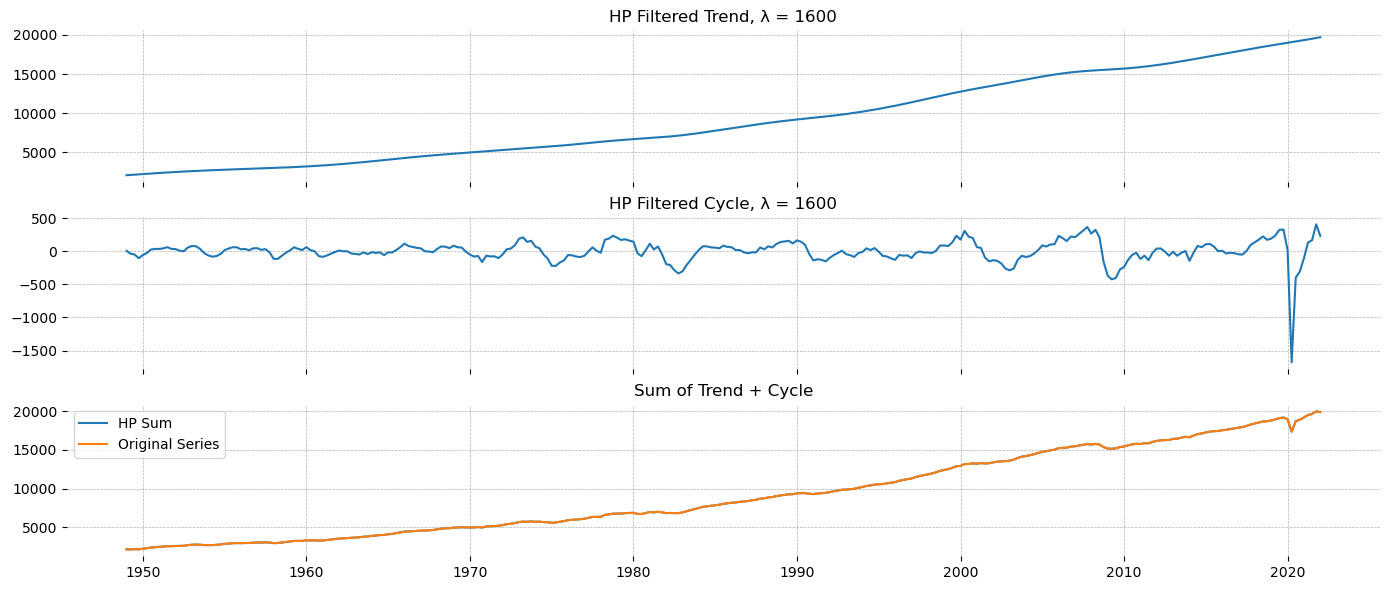

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(14,6), sharex=True)
ax[0].plot(trend)
ax[0].set_title('HP Filtered Trend, λ = 1600')

ax[1].plot(cycle)
ax[1].set_title('HP Filtered Cycle, λ = 1600')

ax[2].plot(trend + cycle, label='HP Sum')
ax[2].plot(y, label='Original Series')
ax[2].set_title('Sum of Trend + Cycle')
ax[2].legend()

fig.tight_layout()
plt.show()

To check our work, we compare the output of the HP filtered GDP series to the potential GDP listed on FRED. It looks like a pretty good match, with caveats. It rates potential GDP as having gone down after the financial crash -- is this reasonable? 

Neverthless, you can see why the HP filter is popular. It's one line of code to implement and we get back two easy-to-understand components. We can use it to get a crude estimate of potential GDP in any country we like, not just those with lots of data to work with.

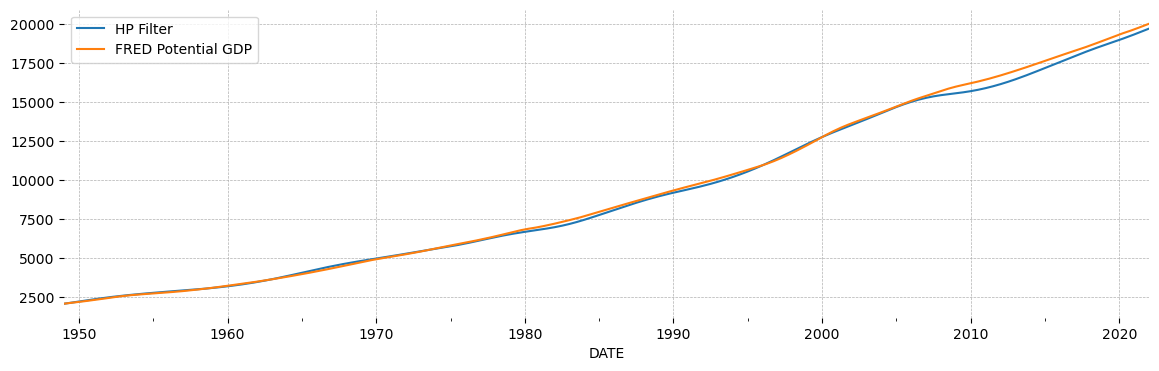

In [13]:
fig, ax = plt.subplots()
trend.plot(ax=ax, label='HP Filter')
fred_data.dropna().GDPPOT.plot(ax=ax, label='FRED Potential GDP')
ax.legend()
plt.show()

# Analysis for a Particular Country

## Phillips Curve

The variable `data` contains world bank data for Real GDP, Unemployment, and Inflation for every available country. Let's pull out one country and see if we can find a Phillips Curve.

Note that this data is annual!

In [14]:
data.head()

GDP  Unemployment_ILO  Unemployment_National  \
country     year                                                       
Afghanistan 1960-01-01  NaN               NaN                    NaN   
            1961-01-01  NaN               NaN                    NaN   
            1962-01-01  NaN               NaN                    NaN   
            1963-01-01  NaN               NaN                    NaN   
            1964-01-01  NaN               NaN                    NaN   

                        Inflation  
country     year                   
Afghanistan 1960-01-01        NaN  
            1961-01-01        NaN  
            1962-01-01        NaN  
            1963-01-01        NaN  
            1964-01-01        NaN

In [15]:
france = data.loc['France']

<AxesSubplot: xlabel='year'>

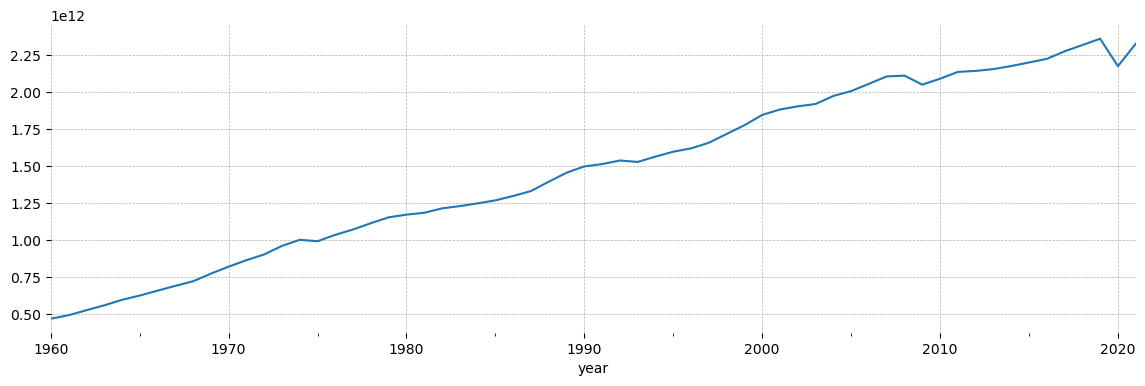

In [16]:
france['GDP'].plot()

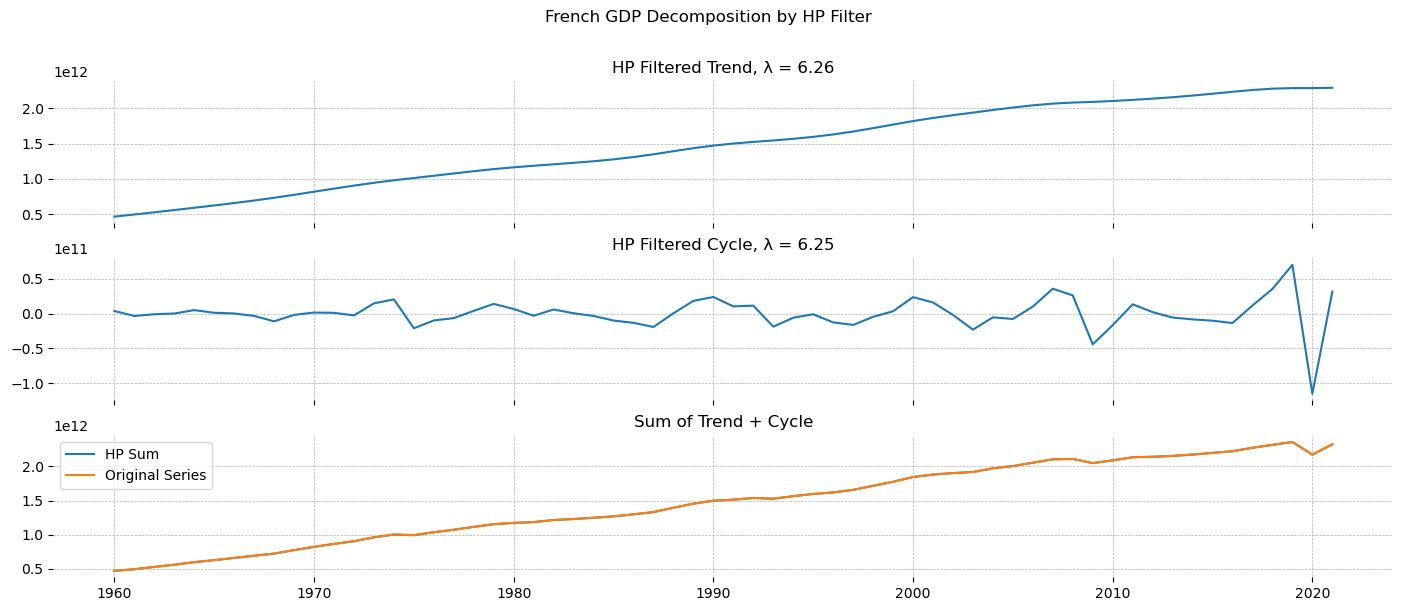

In [27]:
# Since it's annual, we use the suggested lambda of 6.25
cycle, trend = sm.tsa.hp_filter.hpfilter(france.GDP, lamb=6.25)

fig, ax = plt.subplots(3, 1, figsize=(14,6), sharex=True)
ax[0].plot(trend)
ax[0].set_title('HP Filtered Trend, λ = 6.26')

ax[1].plot(cycle)
ax[1].set_title('HP Filtered Cycle, λ = 6.25')

ax[2].plot(trend + cycle, label='HP Sum')
ax[2].plot(france.GDP, label='Original Series')
ax[2].set_title('Sum of Trend + Cycle')
ax[2].legend()

fig.suptitle('French GDP Decomposition by HP Filter', y=1.01)
fig.tight_layout()
plt.show()

<AxesSubplot: title={'center': 'French Output Gap, Estimated by HP Filter'}, xlabel='year'>

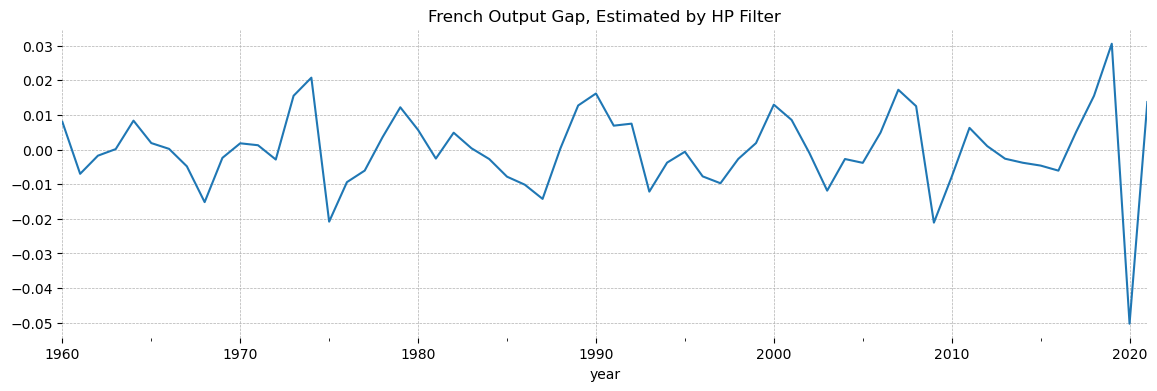

In [28]:
#Since the HP filter is additive, the output gap is just cycle / trend, since GDP = cycle + trend --> cycle = GDP - trend
output_gap = cycle / trend
output_gap.name = 'output_gap'
output_gap.plot(title='French Output Gap, Estimated by HP Filter')

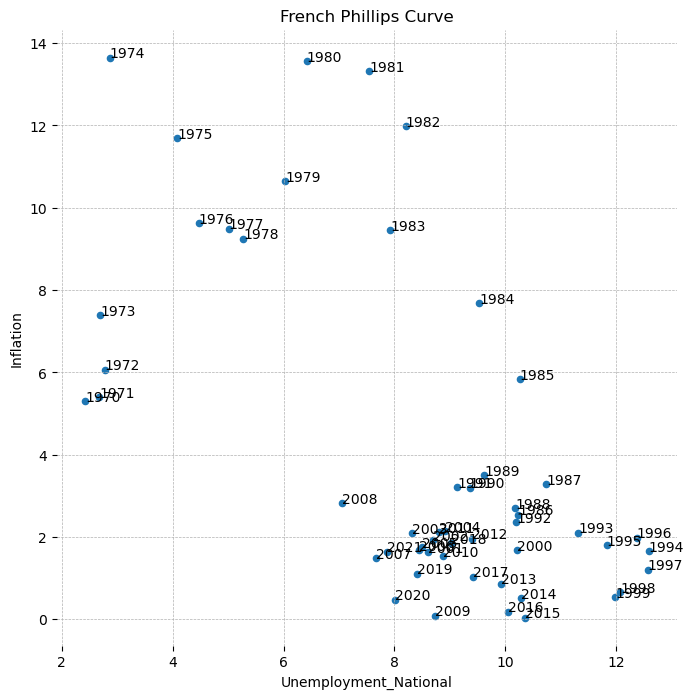

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
x_grid = np.linspace(output_gap.min(), output_gap.max(), 100)
france.join(output_gap)[['Inflation', 'Unemployment_National']].plot.scatter(x='Unemployment_National', y='Inflation', ax=ax, title='French Phillips Curve')
for idx in france.index:
    ax.annotate(idx.year, xy=(france.Unemployment_National.loc[idx], france.Inflation.loc[idx]))
plt.show()

In [20]:
ols = sm.OLS.from_formula('Inflation ~ 1 + Unemployment_National', france)
res = ols.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Inflation   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     32.28
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           6.80e-07
Time:                        15:11:55   Log-Likelihood:                -132.31
No. Observations:                  52   AIC:                             268.6
Df Residuals:                      50   BIC:                             272.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                11.8709      1.440      8.241      0.000       8.978      14.764
Unemployment_National    -0.9264      0.163     -5.682      0.000      -1.254      -0.599
==============================================================================
Omnibus:                        9.024   Durbin-Watson:                   0.211
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.692
Skew:                           0.982   Prob(JB):                       0.0130
Kurtosis:                       3.390   Cond. No.                         29.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Okun's Law

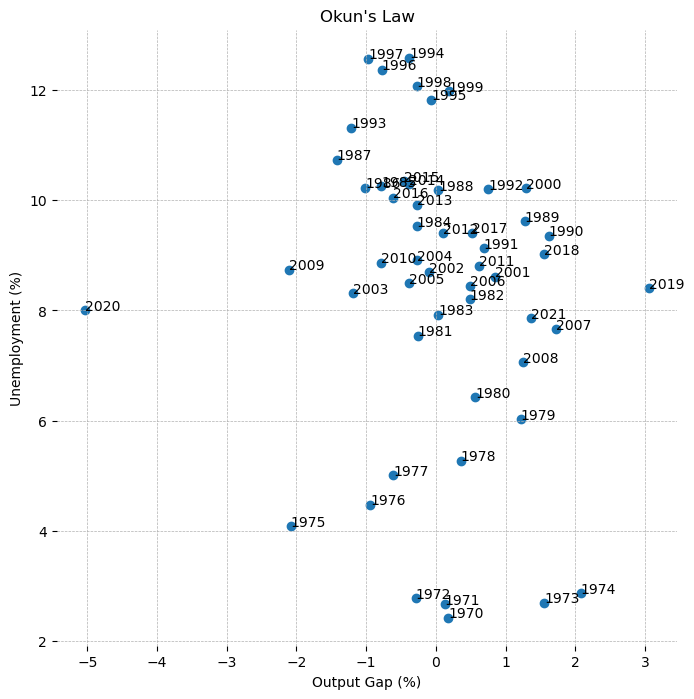

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(output_gap.mul(100), france.Unemployment_National)
for idx in france.index:
    ax.annotate(idx.year, xy=(output_gap.mul(100).loc[idx], france.Unemployment_National.loc[idx]))
ax.set(title="Okun's Law", xlabel='Output Gap (%)', ylabel='Unemployment (%)')
plt.show()

In [22]:
ols = sm.OLS.from_formula('Unemployment_National ~ 1 + output_gap', france.join(output_gap.mul(100)))
res = ols.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Unemployment_National   R-squared:                       0.024
Model:                               OLS   Adj. R-squared:                  0.005
Method:                    Least Squares   F-statistic:                     1.246
Date:                   Sun, 09 Oct 2022   Prob (F-statistic):              0.270
Time:                           15:11:55   Log-Likelihood:                -124.27
No. Observations:                     52   AIC:                             252.5
Df Residuals:                         50   BIC:                             256.4
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4274      0.373     22.567      0.000       7.677       9.177
output_gap    -0.3335      0.299     -1.116      0.270      -0.933       0.266
==============================================================================
Omnibus:                        5.776   Durbin-Watson:                   0.095
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.580
Skew:                          -0.800   Prob(JB):                       0.0614
Kurtosis:                       2.883   Cond. No.                         1.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Replication Exercise

Replicate the same analysis for a country of your choice. Here are a list of all the countries in the World Bank dataset. You can pull any of these out using the `.loc[]` method.

In [23]:
countries = sorted(data.index.get_level_values(0).unique())
countries

['Afghanistan',
 'Africa Eastern and Southern',
 'Africa Western and Central',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Arab World',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Caribbean small states',
 'Cayman Islands',
 'Central African Republic',
 'Central Europe and the Baltics',
 'Chad',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Early-demographic dividend',
 'East

Here are the step you need to follow:

1. Pull the country of interest out of the dataset, then plot the GDP.
2. Use the HP Filter to pull out the estimated potential GDP, and compute the output gap.
3. Plot the output gap.
4. Plot Unemployment_National and Unemployment_ILO. Decide which one would be better for your analysis.
5. Make a Phillips Curve scatterplot. Comment on whether the data matches the theory. Look for any obvious patterns in the years. If it doesn't fit, would it fit for any subsets of years?
6. Run a regression to estimate the slope of the Phillips Curve. Comment.
7. Make an Okun's Law scatterplot. Comment.
8. Run a regression to estimate Okun's Law. Comment.